In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
os.environ['KAGGLE_USERNAME'] = "siddharthbohara"
os.environ['KAGGLE_KEY'] = "KGAT_c9b654bf1af1b9b90046fed85485637a"

In [4]:
def rebalance_validation_set():
    for cls in ['NORMAL', 'PNEUMONIA']:
        val_path = f'chest_xray/val/{cls}'
        train_path = f'chest_xray/train/{cls}'
        if os.path.exists(val_path):
            for f in os.listdir(val_path):
                shutil.move(os.path.join(val_path, f), os.path.join(train_path, f))

    for cls in ['NORMAL', 'PNEUMONIA']:
        files = os.listdir(f'chest_xray/train/{cls}')
        train_f, val_f = train_test_split(files, test_size=0.1, random_state=42)
        os.makedirs(f'chest_xray/val/{cls}', exist_ok=True)
        for f in val_f:
            shutil.move(
                os.path.join(f'chest_xray/train/{cls}', f),
                os.path.join(f'chest_xray/val/{cls}', f)
            )

rebalance_validation_set()

In [5]:
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    return preprocess_input(img)

In [6]:
train_dir = 'chest_xray/train'
val_dir   = 'chest_xray/val'
test_dir  = 'chest_xray/test'

BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

class_names = ['NORMAL', 'PNEUMONIA']

Found 4708 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.9390444810543657), 1: np.float64(0.6737263880938752)}


In [8]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)


In [10]:
history_head = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8987 - loss: 0.2653 - val_accuracy: 0.9332 - val_loss: 0.1493 - learning_rate: 0.0010
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9458 - loss: 0.1426 - val_accuracy: 0.8760 - val_loss: 0.2970 - learning_rate: 0.0010
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 955ms/step - accuracy: 0.9550 - loss: 0.1122 - val_accuracy: 0.9256 - val_loss: 0.1715 - learning_rate: 0.0010
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 144s 972ms/step - accuracy: 0.9605 - loss: 0.1015 - val_accuracy: 0.9466 - val_loss: 0.1187 - learning_rate: 0.0010
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 145s 981ms/step - accuracy: 0.9609 - loss: 0.1010 - val_accuracy: 0.9332 - val_loss: 0.1575 - learning_rate: 0.0010
Epoch 6/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 140s 945ms/step - accuracy: 0.9633 - loss: 0.0903 - val_accuracy: 0.9294 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 7/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 138s 934ms/step - accuracy: 0.

In [11]:
base_model.trainable = True

for layer in base_model.layers[:-60]:
    layer.trainable = False

In [12]:
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9463 - loss: 0.1416 - val_accuracy: 0.9141 - val_loss: 0.2395 - learning_rate: 5.0000e-06
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9611 - loss: 0.0983 - val_accuracy: 0.9313 - val_loss: 0.2013 - learning_rate: 5.0000e-06
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9658 - loss: 0.0869 - val_accuracy: 0.9294 - val_loss: 0.2047 - learning_rate: 5.0000e-06
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.9690 - loss: 0.0761 - val_accuracy: 0.9294 - val_loss: 0.1911 - learning_rate: 1.0000e-06
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9724 - loss: 0.0698 - val_accuracy: 0.9294 - val_loss: 0.1994 - learning_rate: 1.0000e-06


In [13]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 704ms/step - accuracy: 0.8926 - loss: 0.3066
Test Accuracy: 89.26%


In [14]:
y_prob = model.predict(test_gen).ravel()
y_true = test_gen.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 804ms/step


In [15]:
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []

for t in thresholds:
    preds = (y_prob > t).astype(int)
    f1_scores.append(f1_score(y_true, preds))

best_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", best_threshold)

y_pred = (y_prob > best_threshold).astype(int)

Optimal Threshold: 0.36122448979591837


In [16]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.89      0.84      0.87       234
   PNEUMONIA       0.91      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



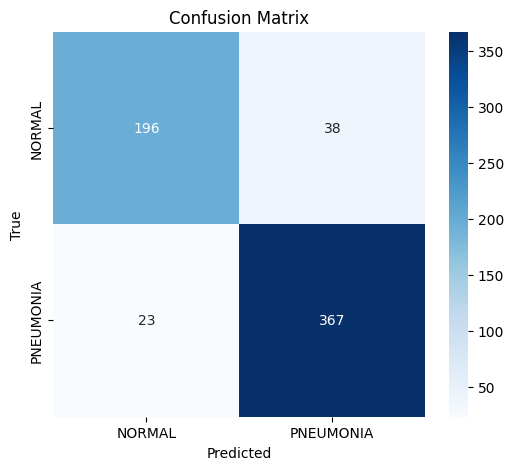

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

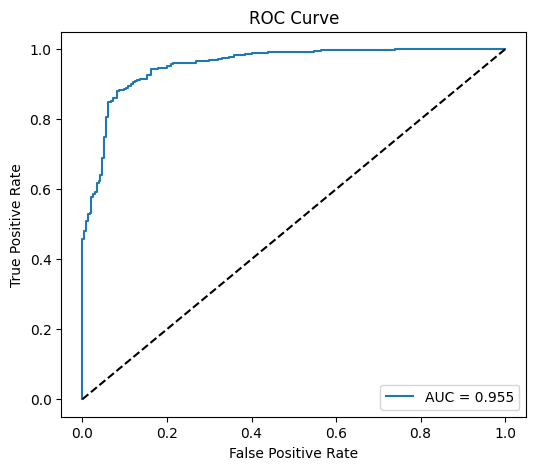

In [19]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [21]:
history = {k: history_head.history[k] + history_fine.history[k] for k in history_head.history}

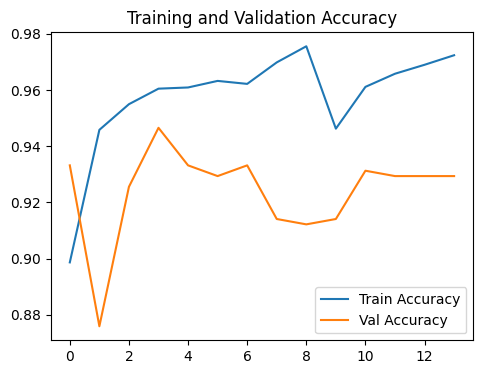

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

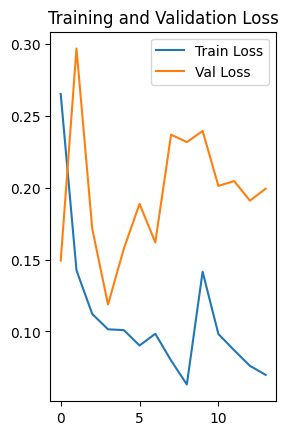

In [23]:
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [24]:
model.save("pneumonia_resnet50_final.h5")
print("Model saved successfully.")

Model saved successfully.


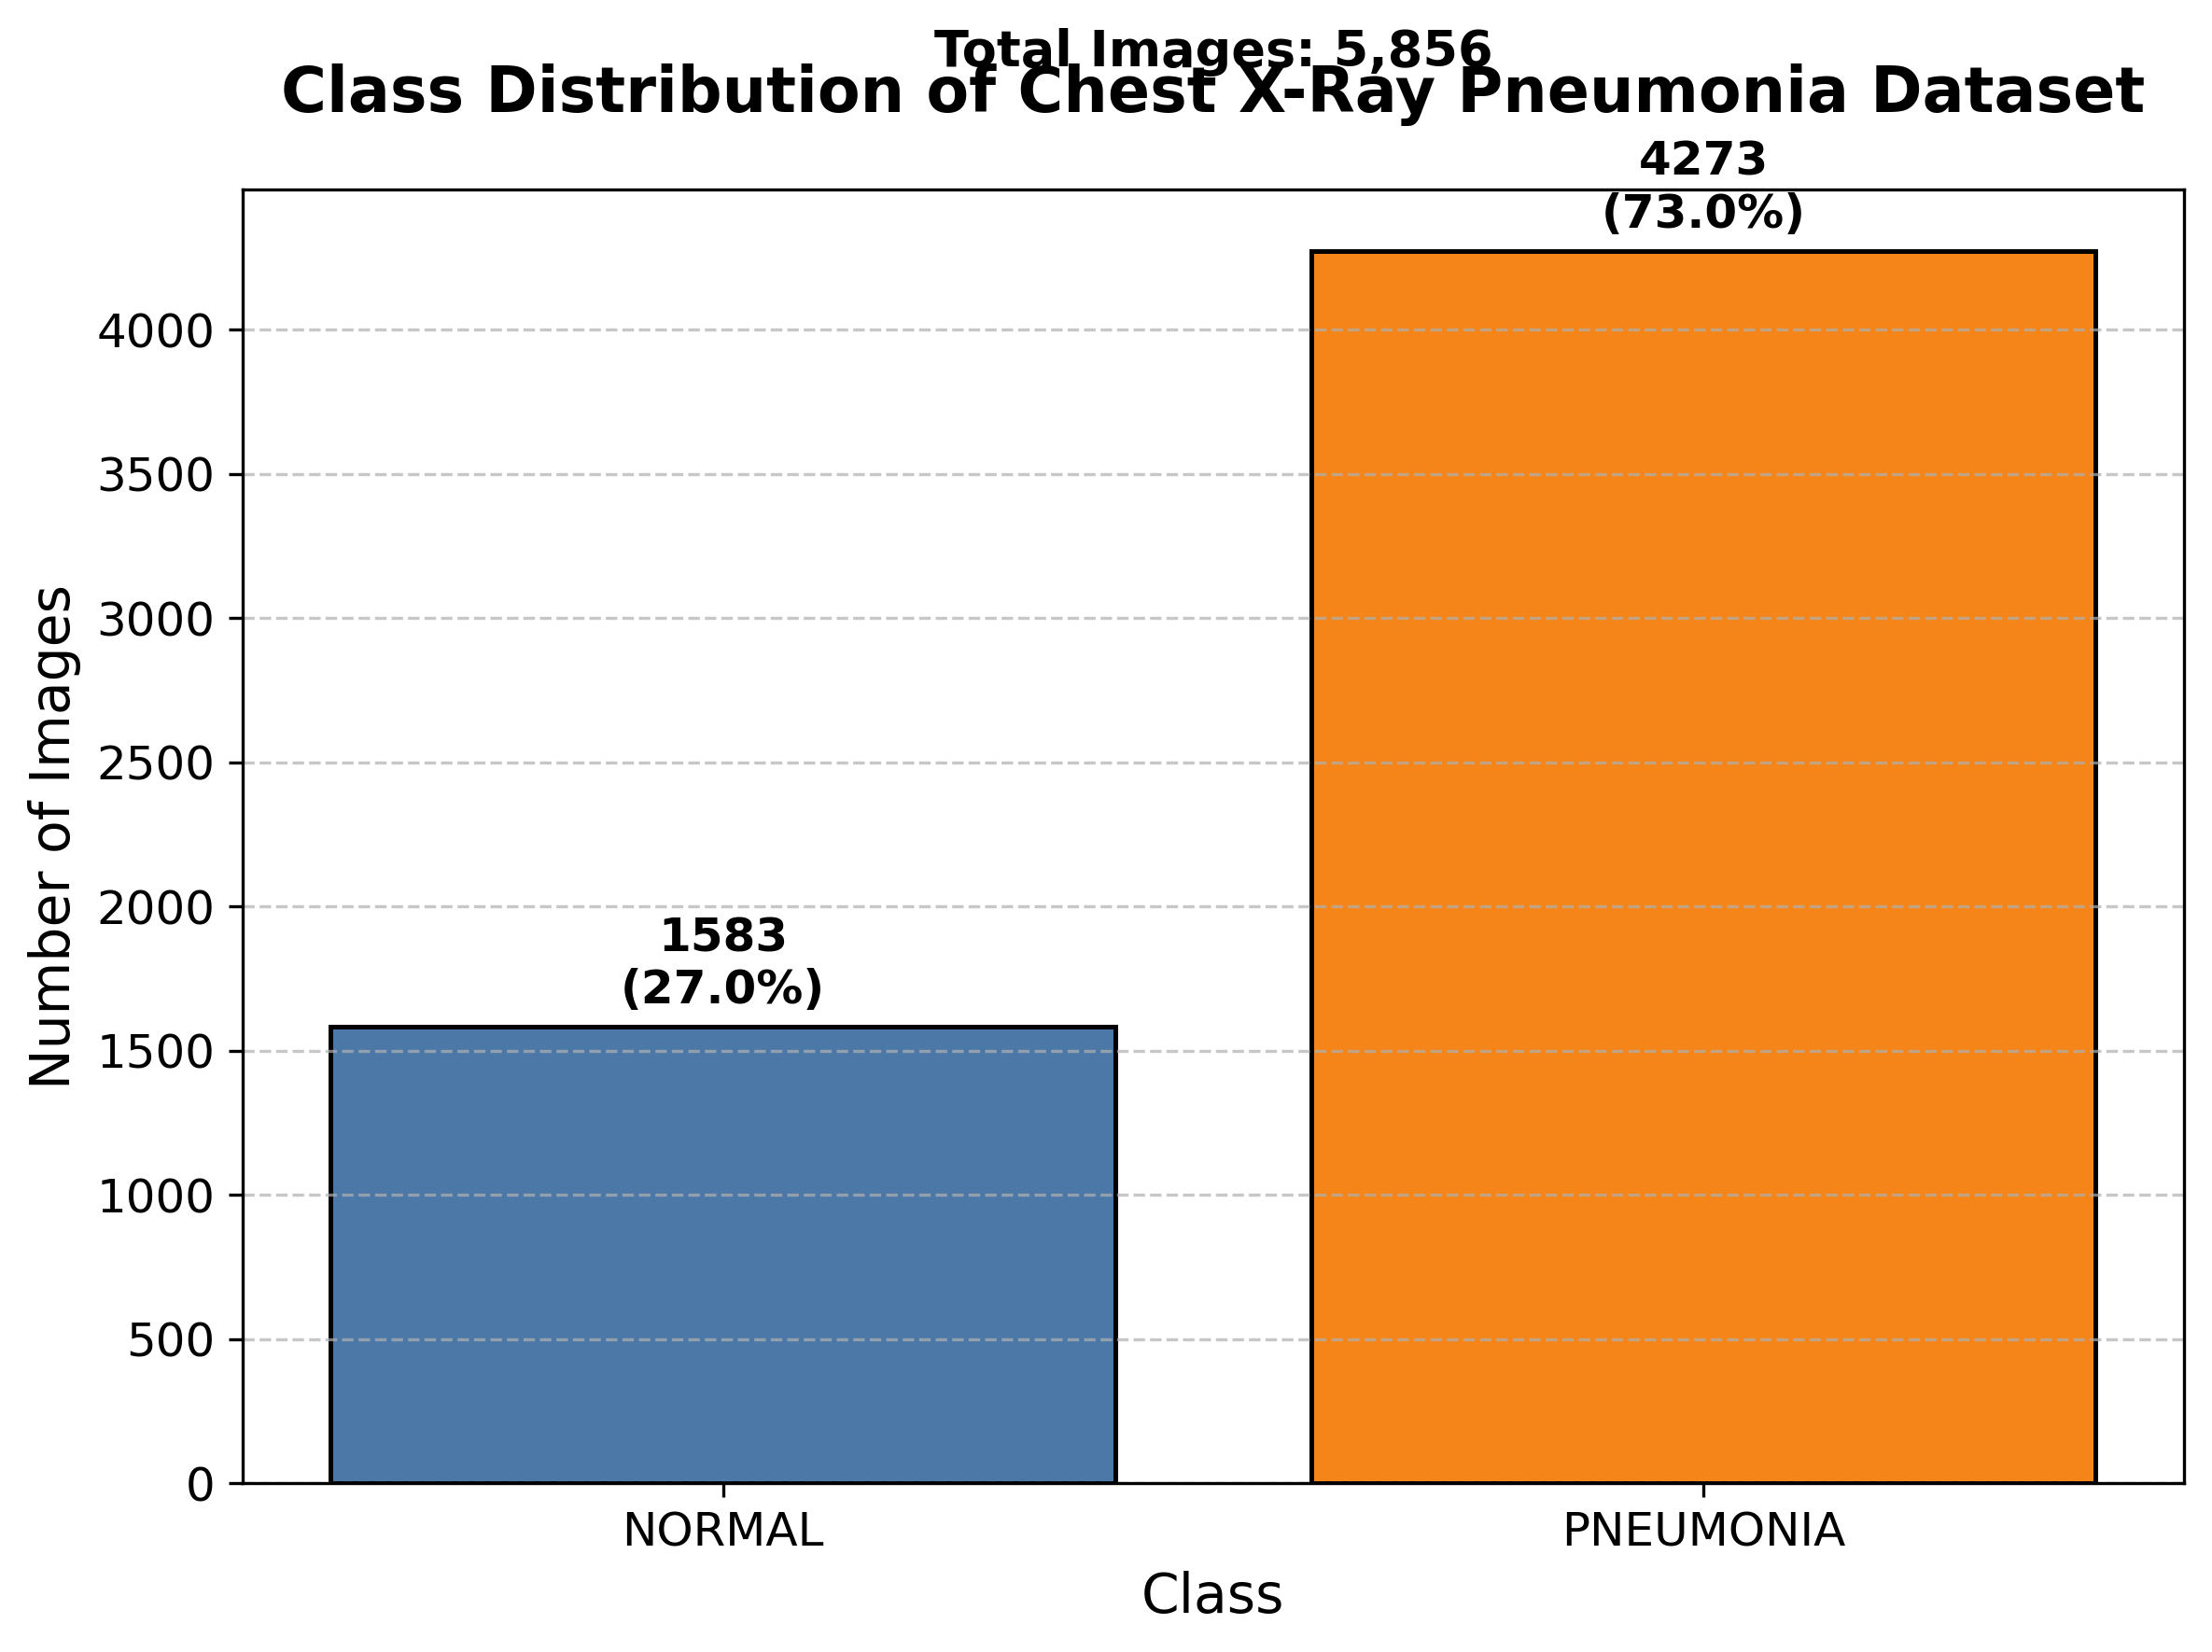

Class distribution chart saved as 'class_distribution.png' – insert into your report.


In [25]:
classes = ['NORMAL', 'PNEUMONIA']
counts = [1583, 4273]
total = sum(counts)
percentages = [count / total * 100 for count in counts]

# Colors: professional medical theme
colors = ['#4C78A8', '#F58518']  # blue for normal, orange for pneumonia

# Create figure
plt.figure(figsize=(8, 6), dpi=300)  # high resolution for report

bars = plt.bar(classes, counts, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for bar, count, pct in zip(bars, counts, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50,
             f'{count}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
plt.title('Class Distribution of Chest X-Ray Pneumonia Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total annotation
plt.text(0.5, max(counts) * 1.15, f'Total Images: {total:,}', 
         ha='center', fontsize=13, fontweight='bold', color='black')

# Adjust layout to prevent clipping
plt.tight_layout()

# Save for report (high quality)
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')

# Show in notebook
plt.show()

print("Class distribution chart saved as 'class_distribution.png' – insert into your report.")

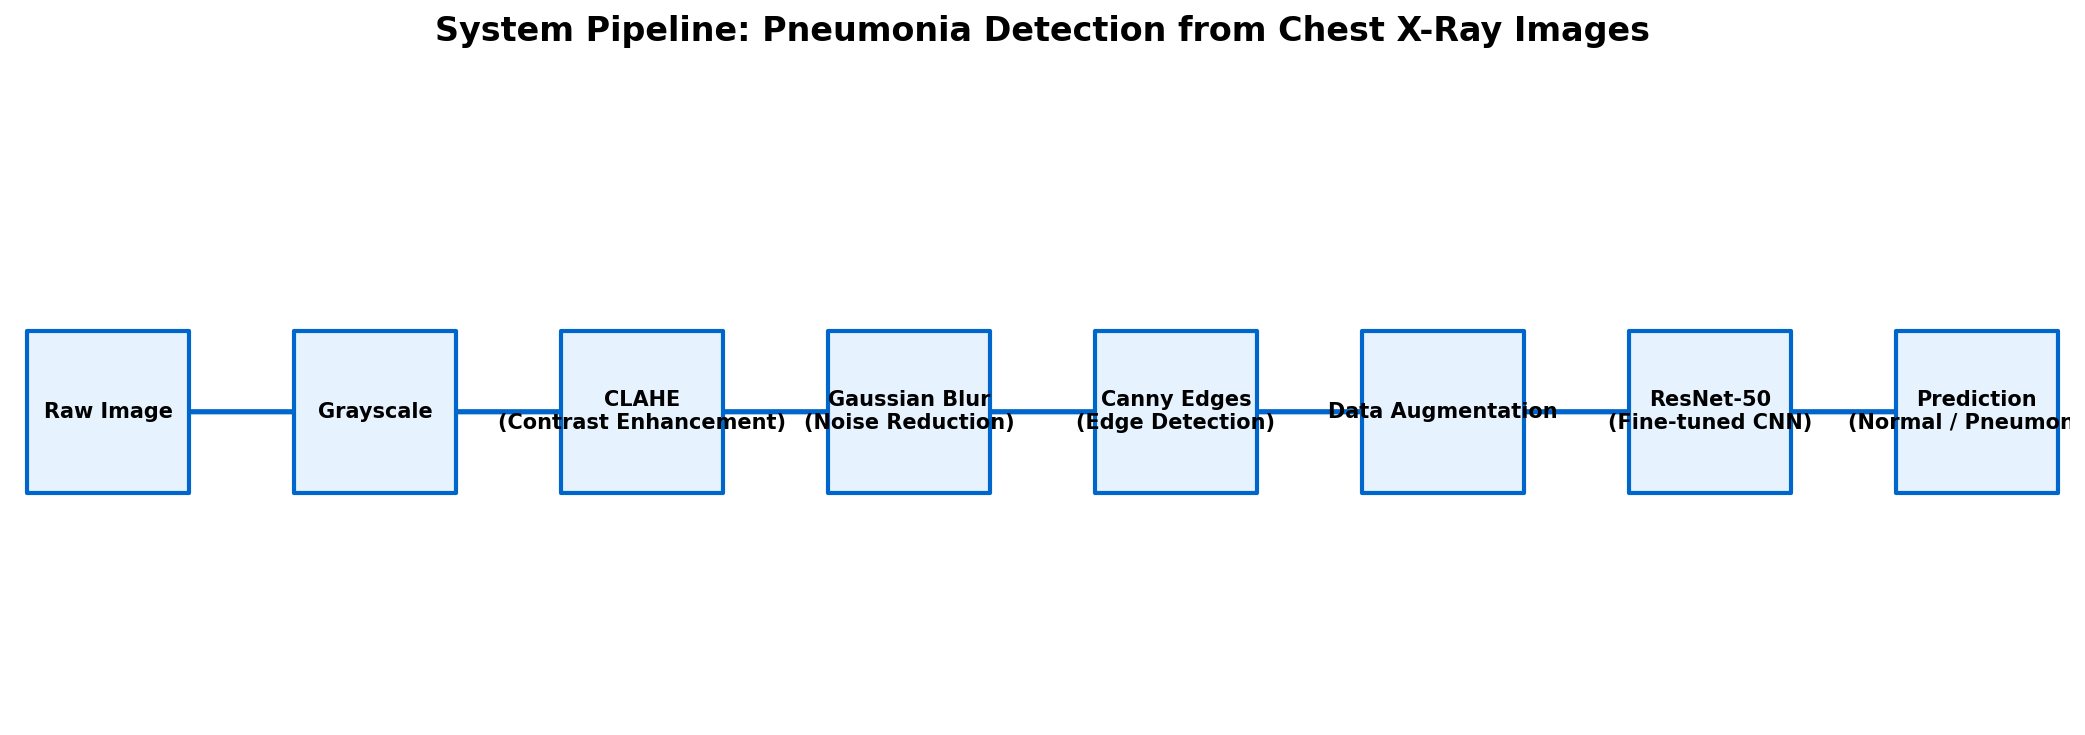

Flowchart saved as 'system_pipeline_flowchart.png' – insert into your report under Section 5 (Methodology / System Design).


In [31]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch

# Create a directed graph
G = nx.DiGraph()

# Define nodes (steps in the pipeline)
steps = [
    "Raw Image",
    "Grayscale",
    "CLAHE\n(Contrast Enhancement)",
    "Gaussian Blur\n(Noise Reduction)",
    "Canny Edges\n(Edge Detection)",
    "Data Augmentation",
    "ResNet-50\n(Fine-tuned CNN)",
    "Prediction\n(Normal / Pneumonia)"
]

# Add nodes with positions (horizontal layout)
pos = {}
for i, step in enumerate(steps):
    pos[step] = (i * 1.8, 0)  # Horizontal spacing

# Add edges (arrows between steps)
for i in range(len(steps) - 1):
    G.add_edge(steps[i], steps[i+1])

# Create figure
fig, ax = plt.subplots(figsize=(14, 5), dpi=150)

# Draw nodes as rounded boxes
nx.draw_networkx_nodes(
    G, pos,
    node_shape='s',
    node_size=6000,
    node_color='#E6F3FF',
    edgecolors='#0066CC',
    linewidths=2,
    ax=ax
)

# Draw edges with fancy arrows
for edge in G.edges():
    arrow = FancyArrowPatch(
        posA=pos[edge[0]],
        posB=pos[edge[1]],
        arrowstyle='->,head_length=0.8,head_width=0.4',
        mutation_scale=20,
        linewidth=2.5,
        color='#0066CC',
        connectionstyle="arc3,rad=0.0"
    )
    ax.add_patch(arrow)

# Draw labels inside nodes
nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight='bold',
    font_color='black',
    verticalalignment='center'
)

# Title and styling
plt.title("System Pipeline: Pneumonia Detection from Chest X-Ray Images", 
          fontsize=16, fontweight='bold', pad=30)

# Remove axes
ax.set_axis_off()

# Adjust layout
plt.tight_layout()

# Save high-quality image for report
plt.savefig("system_pipeline_flowchart.png", dpi=300, bbox_inches='tight', transparent=False)

# Show in notebook
plt.show()

print("Flowchart saved as 'system_pipeline_flowchart.png' – insert into your report under Section 5 (Methodology / System Design).")